# Classification Level 1 

## data loading

In [1]:
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

processed_path = "../data/processed/"
# Load UN-scaled data
X_raw = joblib.load(os.path.join(processed_path, "X_unscaled.joblib"))
y_bin = joblib.load(os.path.join(processed_path, "y_lvl1.joblib"))
print(f"Raw data loaded: {X_raw.shape}")


Raw data loaded: (2827876, 62)


# Data Split And Scaling

In [2]:
# 1. Split FIRST
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
    X_raw, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp_raw, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 2. Fit scaler ONLY on train set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

print(f"Train size: {X_train.shape[0]}")
print(f"Val size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

# Save the scaler for inference
os.makedirs("../data/trained_models/", exist_ok=True)
joblib.dump(scaler, "../data/trained_models/scaler_lvl1.joblib")


Train size: 1979513
Val size: 424181
Test size: 424182


['../data/trained_models/scaler_lvl1.joblib']

In [3]:
import pandas as pd

# Fonction pratique pour afficher le déséquilibre
def check_class_balance(y, name=""):
    counts = pd.Series(y).value_counts()
    percentages = counts / counts.sum() * 100
    print(f"--- Classement pour {name} ---")
    print(counts)
    print("\nPourcentage par classe :")
    print(percentages)
    print("\n")

# Vérifier chaque split
check_class_balance(y_train, "Train")
check_class_balance(y_val, "Validation")
check_class_balance(y_test, "Test")


--- Classement pour Train ---
Binary_Label
0    1589924
1     389589
Name: count, dtype: int64

Pourcentage par classe :
Binary_Label
0    80.318947
1    19.681053
Name: count, dtype: float64


--- Classement pour Validation ---
Binary_Label
0    340698
1     83483
Name: count, dtype: int64

Pourcentage par classe :
Binary_Label
0    80.319015
1    19.680985
Name: count, dtype: float64


--- Classement pour Test ---
Binary_Label
0    340698
1     83484
Name: count, dtype: int64

Pourcentage par classe :
Binary_Label
0    80.318825
1    19.681175
Name: count, dtype: float64




## Entrainement des modèles

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_bin = RandomForestClassifier(
    n_estimators=30,   # moins d’arbres
    max_depth=8,       # profondeur maximale réduite
    min_samples_split=5,  # au moins 5 échantillons pour splitter
    min_samples_leaf=3,   # au moins 3 échantillons par feuille
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)
rf_bin.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3,
                       min_samples_split=5, n_estimators=30, n_jobs=-1,
                       random_state=42)

## Evaluation


=== ÉVALUATION SUR VALIDATION SET ===
--- Validation Report ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    340698
           1       0.97      0.99      0.98     83483

    accuracy                           0.99    424181
   macro avg       0.98      0.99      0.99    424181
weighted avg       0.99      0.99      0.99    424181

ROC-AUC Validation: 0.9995

=== ÉVALUATION FINALE SUR TEST SET ===
--- Test Report ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    340698
           1       0.97      0.99      0.98     83484

    accuracy                           0.99    424182
   macro avg       0.98      0.99      0.99    424182
weighted avg       0.99      0.99      0.99    424182

ROC-AUC Test: 0.9995


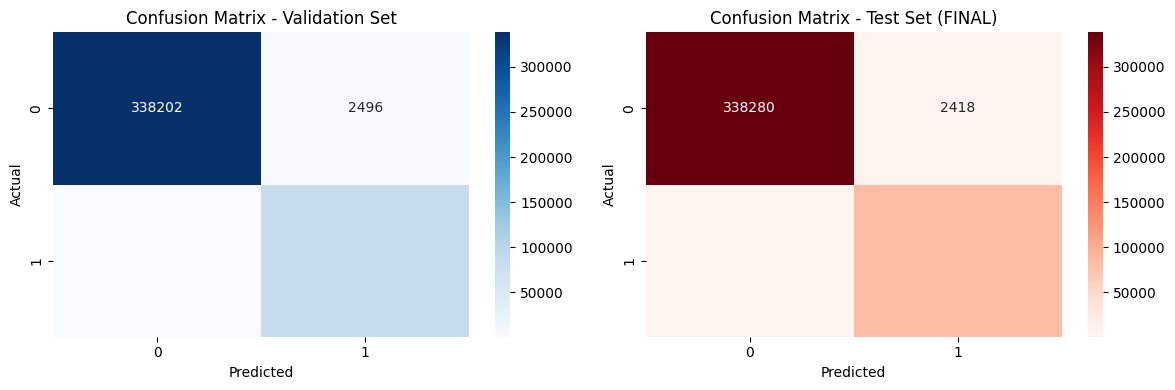


=== COMPARAISON ===
Train Score: 0.9925
Validation Score: 0.9922
Test Score: 0.9925

ROC-AUC Validation: 0.9995
ROC-AUC Test: 0.9995


In [11]:
# 2. ÉVALUATION SUR LE VALIDATION SET (pour tuning)
print("\n=== ÉVALUATION SUR VALIDATION SET ===")
y_val_pred = rf_bin.predict(X_val)
y_val_prob = rf_bin.predict_proba(X_val)[:, 1]

print("--- Validation Report ---")
print(classification_report(y_val, y_val_pred))
roc_val = roc_auc_score(y_val, y_val_prob)
print(f"ROC-AUC Validation: {roc_val:.4f}")

# Matrice de confusion validation
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# 3. ÉVALUATION FINALE SUR LE TEST SET (seulement si satisfait)
print("\n=== ÉVALUATION FINALE SUR TEST SET ===")
y_test_pred = rf_bin.predict(X_test)
y_test_prob = rf_bin.predict_proba(X_test)[:, 1]

print("--- Test Report ---")
print(classification_report(y_test, y_test_pred))
roc_test = roc_auc_score(y_test, y_test_prob)
print(f"ROC-AUC Test: {roc_test:.4f}")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Test Set (FINAL)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# 4. COMPARAISON DES PERFORMANCES
print("\n=== COMPARAISON ===")
print(f"Train Score: {rf_bin.score(X_train, y_train):.4f}")
print(f"Validation Score: {rf_bin.score(X_val, y_val):.4f}")
print(f"Test Score: {rf_bin.score(X_test, y_test):.4f}")
print(f"\nROC-AUC Validation: {roc_val:.4f}")
print(f"ROC-AUC Test: {roc_test:.4f}")

## sauvegarde du model 

In [12]:
# path de sauvegarde des models
model_path = "../data/trained_models/"

# Save the binary model
joblib.dump(rf_bin, os.path.join(model_path, "model_lvl1_binary.joblib"))
print("Model Level 1 saved.")

Model Level 1 saved.
